###  Reuters corpus topic classification

This project is about topic classification on the Reuters corpus. It is multi-label classification: there can be more than one topics associated with each document.

#### Data

Test data will be extracted from XML-documents, taking input from <headline></headline> and <text></text>, target classes from <codes class = 'bip:topics:1.0'><code code = "topic_i"></code></codes>

input: 'document text string, each row a document'
target: ['topic_1', '...', 'topic_n'] = [0, ...., 1, 0]


There are 126 topics that are listed in the topic_codes.txt.


In [66]:
import pandas as pd
import numpy as np


In [14]:
topics = pd.read_csv('mock-data/topic_codes.txt', delimiter='\t')
topics

,CODE,DESCRIPTION
0,1POL,CURRENT NEWS - POLITICS
1,2ECO,CURRENT NEWS - ECONOMICS
2,3SPO,CURRENT NEWS - SPORT
3,4GEN,CURRENT NEWS - GENERAL
4,6INS,CURRENT NEWS - INSURANCE
...,...,...
121,M142,METALS TRADING
122,M143,ENERGY MARKETS
123,MCAT,MARKETS
124,MEUR,EURO CURRENCY


In [15]:
codes = topics['CODE']
codes

0       1POL
1       2ECO
2       3SPO
3       4GEN
4       6INS
       ...  
121     M142
122     M143
123     MCAT
124     MEUR
125    PRB13
Name: CODE, Length: 126, dtype: object

I will first manually create a small mock data to start model development.

In [56]:
mini_texts = pd.read_csv('mock-data/text_snippets.csv', delimiter=';')
mini_texts

,text,target
0,REUTER EC REPORT LONG-TERM DIARY FOR APR 7 - D...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Brascade Resources Inc Q1 shr falls,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,U.S. corporate bonds - new issue pricings,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
3,CBES Bancorp Inc Q3 March 31 net rises,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,H&R Block chief financial officer resigns,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,General Kinetics consents to delisting,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [59]:
#empty_topic_vec = [0] * 126
#mock_documents = list(mini_texts.text.values)
#mock_labels = list(mini_texts.target.values)

### Exploring code combination distribution

Now there is the actual data in a csv file, let's do some analysis on it.

Five of the code combinations are quite common, there are 20 000 -10 000 examples for them.

Half of the combinations however have only one example.


In [139]:
trunc_large_data_strings = pd.read_csv('reuters-csv/inputs_trunc.csv', delimiter=';')

In [140]:
trunc_large_data_strings.describe

<bound method NDFrame.describe of                                                      text  \
0       Official Journal contents - OJ C 169 of June 4...   
1       Official Journal contents - OJ L 144 of June 4...   
2       Suncor lowers Canada heavy oil price. COMPANY ...   
3       Suncor cuts Canada light oil prices. COMPANY E...   
4       Toronto stocks end softer, more consolidation ...   
...                                                   ...   
299768  Reuters French Advertising & Media Digest -Jul...   
299769  Fleming issues buy recommendation on M6. Flemi...   
299770  China to launch Internet service for science d...   
299771  Reuters German Advertising & Media Digest -Jul...   
299772  Singapore Internet gets boost from television ...   

                                                   target  \
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [141]:
code_freqs = trunc_large_data_strings['codes'].value_counts()
code_freqs

['C15', 'C151', 'CCAT']                                     22203
['C15', 'C152', 'CCAT']                                     19751
['M11', 'MCAT']                                             15791
['M14', 'M141', 'MCAT']                                     14675
['GCAT', 'GSPO']                                            12390
                                                            ...  
['C12', 'C13', 'CCAT', 'GCAT', 'GCRIM', 'GENV', 'GPOL']         1
['C13', 'CCAT', 'E12', 'ECAT', 'GCAT', 'GODD']                  1
['C13', 'C17', 'C171', 'C18', 'C183', 'C34', 'CCAT']            1
['C15', 'C152', 'C31', 'CCAT', 'GCAT', 'GENT']                  1
['E51', 'E512', 'ECAT', 'GCAT', 'GCRIM', 'GDEF', 'GPOL']        1
Name: codes, Length: 8326, dtype: int64

In [146]:
# these are more frecuent
code_freq_df = code_freqs.to_frame()
code_freq_df

,codes
"['C15', 'C151', 'CCAT']",22203
"['C15', 'C152', 'CCAT']",19751
"['M11', 'MCAT']",15791
"['M14', 'M141', 'MCAT']",14675
"['GCAT', 'GSPO']",12390
...,...
"['C12', 'C13', 'CCAT', 'GCAT', 'GCRIM', 'GENV', 'GPOL']",1
"['C13', 'CCAT', 'E12', 'ECAT', 'GCAT', 'GODD']",1
"['C13', 'C17', 'C171', 'C18', 'C183', 'C34', 'CCAT']",1
"['C15', 'C152', 'C31', 'CCAT', 'GCAT', 'GENT']",1


In [147]:
frequent_combos = code_freq_df[code_freq_df['codes']>10000]
frequent_combos

,codes
"['C15', 'C151', 'CCAT']",22203
"['C15', 'C152', 'CCAT']",19751
"['M11', 'MCAT']",15791
"['M14', 'M141', 'MCAT']",14675
"['GCAT', 'GSPO']",12390


In [148]:
rare_combos = code_freq_df[code_freq_df['codes']<10]
rare_combos

,codes
"['C13', 'C17', 'C173', 'CCAT']",9
"['M11', 'M13', 'M131', 'M132', 'MCAT']",9
"['E41', 'ECAT', 'GCAT', 'GCRIM', 'GJOB', 'GPOL']",9
"['GCAT', 'GFAS', 'GOBIT', 'GPRO']",9
"['C11', 'C18', 'C181', 'C182', 'CCAT']",9
...,...
"['C12', 'C13', 'CCAT', 'GCAT', 'GCRIM', 'GENV', 'GPOL']",1
"['C13', 'CCAT', 'E12', 'ECAT', 'GCAT', 'GODD']",1
"['C13', 'C17', 'C171', 'C18', 'C183', 'C34', 'CCAT']",1
"['C15', 'C152', 'C31', 'CCAT', 'GCAT', 'GENT']",1


In [150]:
code_freq_df[code_freq_df['codes']==1]

,codes
"['E12', 'GPOL', 'GVOTE', 'M132']",1
"['C11', 'C15', 'C152', 'C17', 'C171', 'C41', 'C411', 'CCAT']",1
"['C24', 'CCAT', 'GCAT', 'GDEF', 'GSCI']",1
"['C13', 'C15', 'CCAT', 'G15', 'G152', 'GCAT']",1
"['C11', 'C13', 'C18', 'C181', 'C34', 'CCAT', 'G15', 'G152', 'G157', 'GCAT']",1
...,...
"['C12', 'C13', 'CCAT', 'GCAT', 'GCRIM', 'GENV', 'GPOL']",1
"['C13', 'CCAT', 'E12', 'ECAT', 'GCAT', 'GODD']",1
"['C13', 'C17', 'C171', 'C18', 'C183', 'C34', 'CCAT']",1
"['C15', 'C152', 'C31', 'CCAT', 'GCAT', 'GENT']",1


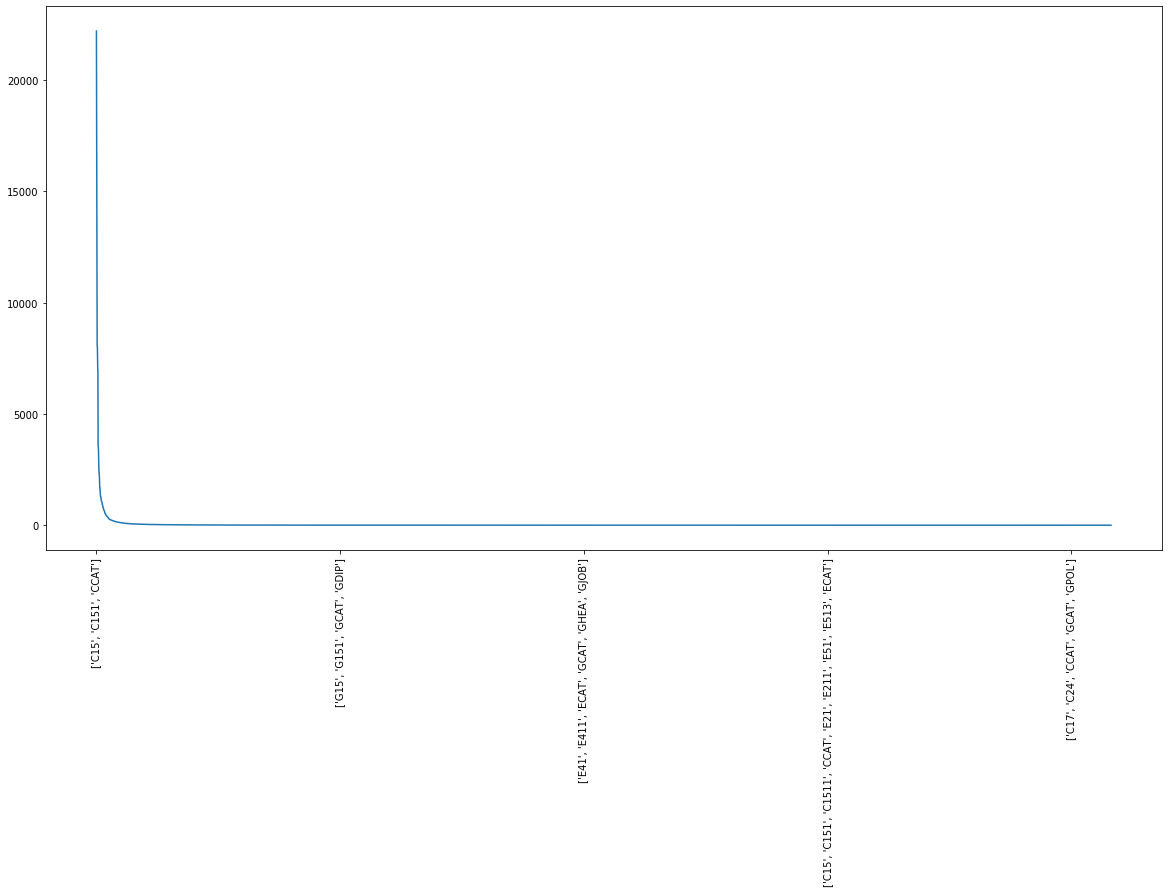

In [135]:
import matplotlib.pyplot as plt

code_freqs.plot(figsize=(20,10), rot=90)

### Loading a mini training set

Next I will take some of the data to make a train, validation and test set for model development, each a size of 10 000 rows. 

In [98]:
#  because of the target and codes are stored as strings and not as list, I will convert them back to lists
trunc_large_data = trunc_large_data_strings.copy(deep=True)
trunc_large_data['target'] = trunc_large_data['target'].apply(eval)
trunc_large_data['codes'] = trunc_large_data['codes'].apply(eval)

In [99]:
trunc_large_data_shuf = trunc_large_data.sample(frac=1, random_state=42) # shuffle all data rows
mini_train = trunc_large_data_shuf[:10000]
mini_dev = trunc_large_data_shuf[10000:20000]
mini_test = trunc_large_data_shuf[20000:30000]

### Trying out transformer and BERT

Next I will be trying out things presented in a blog post: [Transformers for Multi-Label Classification made simple.](https://towardsdatascience.com/transformers-for-multilabel-classification-71a1a0daf5e1)

I will also utilize some code from the home exercises of Deep Learning course.

In [77]:
import torch
import torch.nn as nn
from transformers import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [106]:
# mini sets to lists

train_mini_documents = list(mini_train.text.values)
train_mini_labels = list(mini_train.target.values)
dev_mini_documents = list(mini_dev.text.values)
dev_mini_labels = list(mini_dev.target.values)

In [86]:
doc_max_length = 256 # using the truncated mini train set sequence length
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 

# train data encodings

train_encodings = tokenizer.batch_encode_plus(train_mini_documents,max_length=doc_max_length,pad_to_max_length=True) # tokenizer's encoding method
train_input_ids = train_encodings['input_ids'] # tokenized and encoded sentences
train_token_type_ids = train_encodings['token_type_ids'] # token type ids
train_attention_masks = train_encodings['attention_mask'] # attention masks

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [84]:
# validation data encodings

dev_encodings = tokenizer.batch_encode_plus(dev_mini_documents,max_length=doc_max_length,pad_to_max_length=True) # tokenizer's encoding method
dev_input_ids = dev_encodings['input_ids'] # tokenized and encoded sentences
dev_token_type_ids = dev_encodings['token_type_ids'] # token type ids
dev_attention_masks = dev_encodings['attention_mask'] # attention masks

In [107]:
# change to tensors

mini_train_inputs = torch.tensor(train_input_ids)
mini_train_labels = torch.tensor(train_mini_labels)
mini_train_masks = torch.tensor(train_attention_masks)
mini_train_token_types = torch.tensor(train_token_type_ids)

mini_dev_inputs = torch.tensor(dev_input_ids)
mini_dev_labels = torch.tensor(dev_mini_labels)
mini_dev_masks = torch.tensor(dev_attention_masks)
mini_dev_token_types = torch.tensor(dev_token_type_ids)

In [110]:
print(mini_train_inputs.shape)
print(mini_train_labels.shape)
print(mini_train_masks.shape)
print(mini_train_token_types.shape)

torch.Size([10000, 256])
torch.Size([10000, 126])
torch.Size([10000, 256])
torch.Size([10000, 256])


In [113]:
# create train iterator with torch dataloader

from torch.utils.data import TensorDataset, DataLoader, RandomSampler
batch_size = 48

mini_train_data = TensorDataset(mini_train_inputs, mini_train_masks, mini_train_labels, mini_train_token_types)
mini_train_sampler = RandomSampler(mini_train_data)
mini_train_dataloader = DataLoader(mini_train_data, sampler=mini_train_sampler, batch_size=batch_size)


In [114]:
# create dev iterator with torch dataloader

mini_dev_data = TensorDataset(mini_dev_inputs, mini_dev_masks, mini_dev_labels, mini_dev_token_types)
mini_dev_sampler = SequentialSampler(mini_dev_data)
mini_dev_dataloader = DataLoader(mini_dev_data, sampler=mini_dev_sampler, batch_size=batch_size)

In [115]:
# save (file sizes are around 70 MB for mini loaders, so these are gitignored)

torch.save(mini_train_dataloader,'data-loaders/mini-train_data_loader')
torch.save(mini_dev_dataloader,'data-loaders/mini-dev_data_loader')

### Model loading, initial optimizer and criterion

The huggingface transformers have AdamW that has gradient bias correction and weight decay. The optimizer hyperparemeters can be [customised](https://huggingface.co/transformers/training.html), but I start simple with the default settings.

In [ ]:
# Model 1

NUM_LABELS = 126 # amount of the different topics

model_1 = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model_1.to(device)

optimizer_1 = AdamW(model_1.parameters(), lr=1e-5)